# Student Performance Classification

This notebook performs EDA and model evaluation for the synthetic student dataset. It mirrors the `src/train.py` script but is interactive for plotting and exploration.

In [11]:
# Imports and setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='whitegrid')
%matplotlib inline


In [9]:
# Load dataset
df = pd.read_csv('../data/students.csv')
print('Rows, cols:', df.shape)
df.head()

# Quick missing value summary
print('\nMissing values per column:')
print(df.isna().sum())


Rows, cols: (500, 5)

Missing values per column:
MST_Score           5
Quiz_Avg            5
Attendance          0
Assignment_Score    5
Category            0
dtype: int64


c:\Users\tabasum\Desktop\SmartEdu_Classifier\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tabasum\Desktop\SmartEdu_Classifier\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tabasum\Desktop\SmartEdu_Classifier\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tabasum\Desktop\SmartEdu_Classifier\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na 

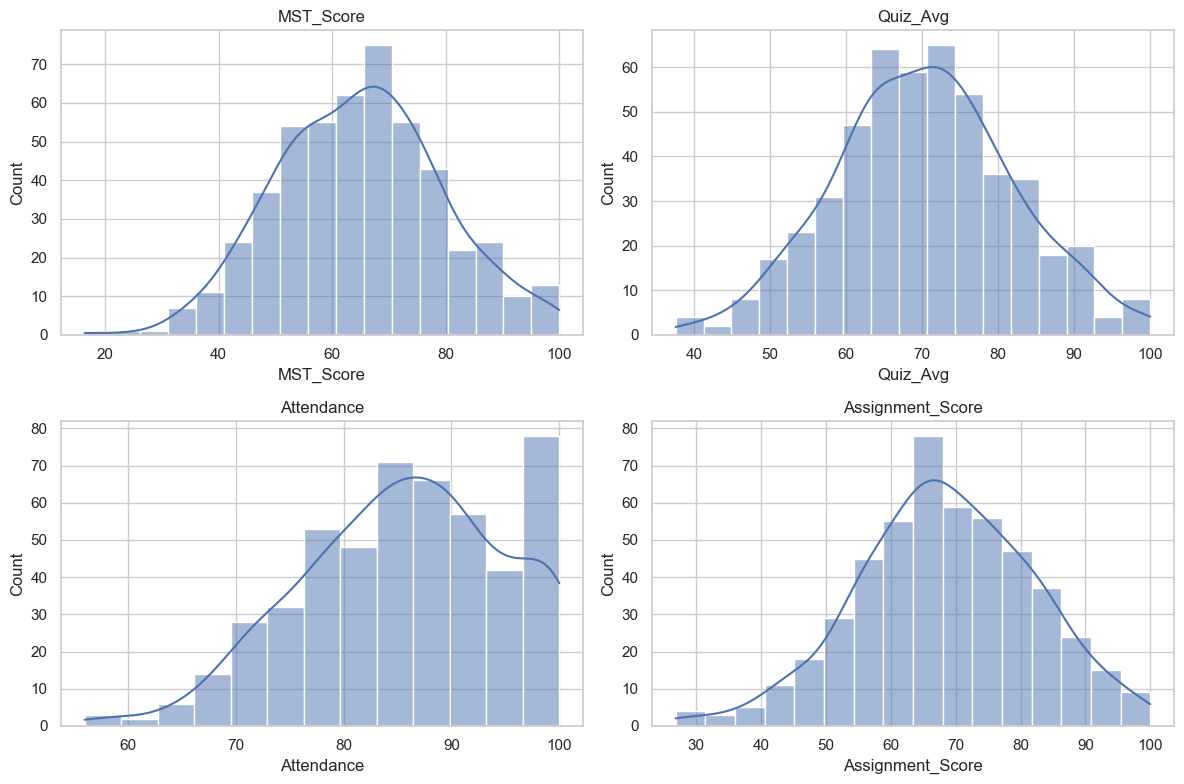

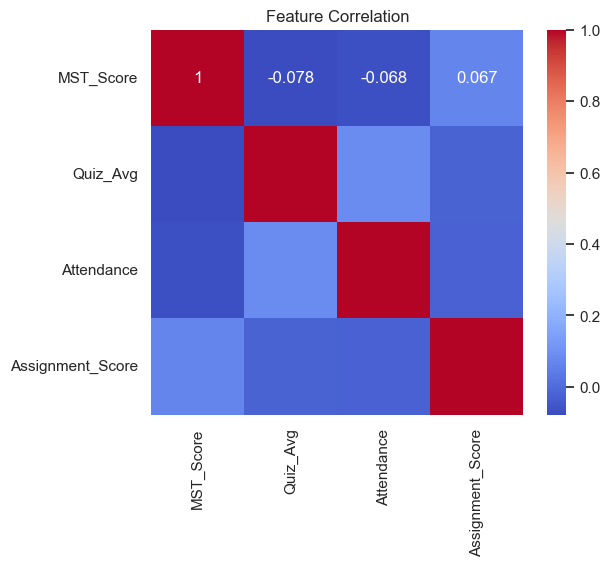


Classification report for saved model:
                   precision    recall  f1-score   support

Average Performer       0.93      1.00      0.97        84
   High Performer       1.00      0.94      0.97        34
Needs Improvement       1.00      0.43      0.60         7

         accuracy                           0.95       125
        macro avg       0.98      0.79      0.85       125
     weighted avg       0.96      0.95      0.95       125



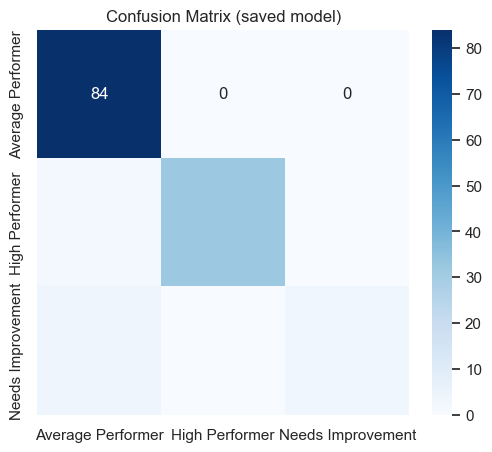

In [12]:
# EDA: distributions and correlation
features = ['MST_Score','Quiz_Avg','Attendance','Assignment_Score']
plt.figure(figsize=(12,8))
for i, col in enumerate(features, 1):
    plt.subplot(2,2,i)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(col)
plt.tight_layout()

plt.figure(figsize=(6,5))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

# Load saved model (if present) and evaluate on held-out set using same preprocessing as src/train.py
model_path = '../models/best_model.joblib'
if os.path.exists(model_path):
    artifacts = joblib.load(model_path)
    model = artifacts['model']
    scaler = artifacts['scaler']
    imputer = artifacts['imputer']
    le = artifacts['label_encoder']

    X = df[features].copy()
    X_imp = pd.DataFrame(imputer.transform(X), columns=features)
    X_scaled = pd.DataFrame(scaler.transform(X_imp), columns=features)

    # We'll do a quick train/test split similar to script
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, le.transform(df['Category']), test_size=0.25, random_state=42, stratify=le.transform(df['Category']))

    preds = model.predict(X_test)
    print('\nClassification report for saved model:')
    print(classification_report(y_test, preds, target_names=le.classes_))
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    plt.title('Confusion Matrix (saved model)')
    plt.show()
else:
    print('No saved model found at', model_path)
